b shape: (3238, 3741)
g shape: (3238, 3741)
r shape: (3238, 3741)


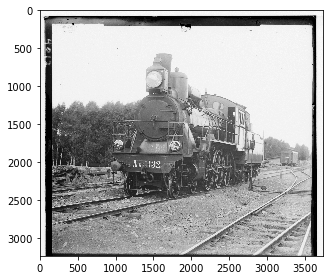

In [691]:
# CS194-26 (CS294-26): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
from timeit import default_timer as timer
import skimage.transform

pic_name = 'train'

# name of the input file
imname = 'input/' + pic_name + '.tif'

# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)
    
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(np.int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]
skio.imshow(b)
print("b shape:", b.shape)
print("g shape:", g.shape)
print("r shape:", r.shape)

In [692]:
# # Manually crop the boundaries
# bound = 200
# b = b[bound:b.shape[0] - bound, bound:b.shape[1] - bound]
# g = g[bound:g.shape[0] - bound, bound:g.shape[1] - bound]
# r = r[bound:r.shape[0] - bound, bound:r.shape[1] - bound]
# print(b.shape)
# skio.imshow(r)

In [693]:
def ssd(img, ref):
    # this function calculates the ssd between two images to see how aligned they are.
    # They lower the return value, the more aligned they are.
    diff = img - ref
    diff = diff ** 2;
    ret = np.sum(diff)
    return ret

In [694]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)
def align(img, ref, maxOffset, startingPos = (0, 0)):
    # Align array with reference. return the best offsets and the aligned array.
    
    # 1. For the exhaust search
    # the function will try -15 to +15 on x axis and y axis, 
    # remember the best displacement pair
    minErr = float('inf')
    bestImg = img
    best_offset_x = 0
    best_offset_y = 0
    for i in range(-maxOffset + startingPos[1], maxOffset + startingPos[1]):
        # i is the offset on the y axis, positive means shift downwards
        for j in range(-maxOffset + startingPos[0], maxOffset + startingPos[0]):
            # j is the offset on the x axis, positive means shift to the right
            newImg = np.roll(img, (i, j), (0 ,1))
            err = ssd(newImg, ref)
            if err < minErr:
                minErr = err
                bestImg = newImg
                best_offset_x = j
                best_offset_y = i
    return (best_offset_x, best_offset_y), bestImg
    

In [695]:
# The recursive pyramid search function
def pyramid(img, ref, maxOffset):
    numLayer = 5
    offSetPos = (0, 0)
    for i in range(numLayer):
        scaledImg = sk.transform.rescale(img, (1/2) ** (numLayer - i - 1))
        scaledRef = sk.transform.rescale(ref, (1/2) ** (numLayer - i - 1))
        offSetPos = (offSetPos[0] * 2, offSetPos[1] * 2)
        retAlign = align(scaledImg, scaledRef, maxOffset, offSetPos)
        offSetPos = retAlign[0]
        maxOffset = 1 # after the initial search, each pixel in the upper level is split into 4 smaller pixels. 
        print(offSetPos)
    return retAlign

(0, 7)
(-1, 14)
(-2, 28)
(-4, 55)
(-8, 110)
(0, 6)
(0, 12)
(0, 24)
(0, 48)
(0, 96)
best offset on the x axis in g->b: -8
best offset on the y axis in g->b: 110
best offset on the x axis in r->b: 0
best offset on the y axis in r->b: 96


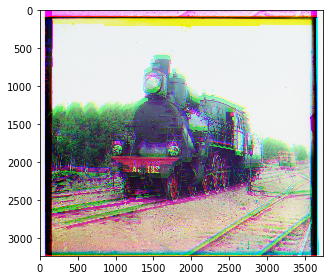

elapsed time:  35.03311850002501


In [696]:
start = timer()
# ag = align(g, b, 15)
# ar = align(r, b, 15)
ag = pyramid(g, b, 15)
ar = pyramid(r, b, 15)

# create a color image
im_out = np.dstack([ar[1], ag[1], b])
print("best offset on the x axis in g->b:", ag[0][0])
print("best offset on the y axis in g->b:", ag[0][1])

print("best offset on the x axis in r->b:", ar[0][0])
print("best offset on the y axis in r->b:", ar[0][1])

im_out = 255 * im_out # Now scale by 255
im_out = im_out.astype(np.uint8)

# save the image
# fname = './output/' + pic_name + '_ssd.jpg'
fname = './output/' + pic_name + '_ssd_pyramid.jpg'
# fname = './output/' + pic_name + '_ssd_pyramid_manual_crop.jpg'
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

#end the timer and calculate elapsed time
end = timer()
print("elapsed time: ", end - start)